In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
#Method 1: Using Analytical solutions of Black Scholes PDE

def sqrt(x):    #Babylonian method of finding square root
    n = 1
    for _ in range(10):
        n = (n + x/n) * 0.5
    return n

def my_cdf(x):  #Generating cumulative distrbution function
    return 0.5*(1+math.erf(x/sqrt(2)))

#Valuing European Call and Put Options directly from solutions of Black Scholes PDE
def d1(S,K,r,T,sigma):
    return (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
def d2(S,K,r,T,sigma):    
    return (np.log(S/K)+(r-0.5*sigma**2)*T)/(sigma*sqrt(T))
def EuropeanCall(S, K, T, r, sigma):
    EuropeanCall=S*my_cdf(d1(S,K,r,T,sigma))-K*np.exp(-r*T)*my_cdf(d2(S,K,r,T,sigma))
    return(EuropeanCall)
def EuropeanPut(S, K, T, r, sigma):
    EuropeanPut=K*np.exp(-r*T)*my_cdf(-d2(S,K,r,T,sigma))-S*my_cdf(-d1(S,K,r,T,sigma))
    return(EuropeanPut)
print(f"Value of European Call is: {round(EuropeanCall(50, 55, 252, 0.01,0.4),2)}")
print(f"Value of European Put is: {round(EuropeanPut(50, 55, 252, 0.01,0.4),2)}")

Value of European Call is: 49.98
Value of European Put is: 4.4


In [3]:
def EuropeanCall_comparison(S, K, T, r, sigma):
    K = np.random.uniform(S,5*K,K)
    K = [math.trunc(K[i]) for i in range(len(K))]
    call_estimates = [round(EuropeanCall(S, K[i], T, r, sigma),2) for i in range(len(K))]
    return K , call_estimates

In [4]:
df = EuropeanCall_comparison(100,110,2,0.01,0.4)
df = pd.DataFrame(df)
df = df.T
df.columns = ["Strike Price", "Value of Call Option"]
df = df.sort_values(by = ['Strike Price'])
df

,Strike Price,Value of Call Option
6,101.0,22.66
29,102.0,22.28
22,110.0,19.43
61,118.0,16.95
44,130.0,13.83
...,...,...
78,532.0,0.06
72,535.0,0.06
103,545.0,0.06
46,545.0,0.06


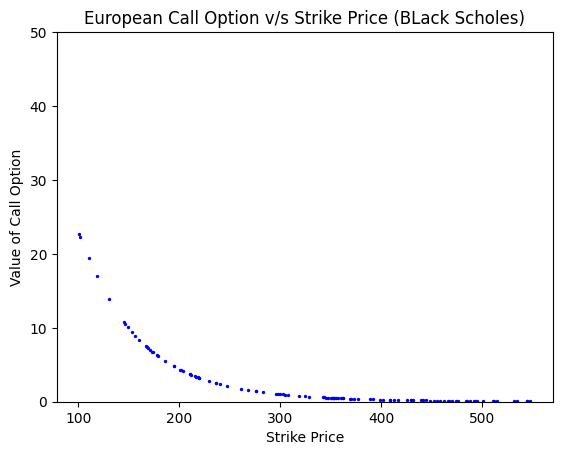

In [5]:
xpoints = df['Strike Price']
ypoints = df['Value of Call Option']
plt.scatter(xpoints, ypoints, s=2, color = 'blue')
plt.ylim(0,50)
#plt.hlines(y=math.pi, xmin = 0, xmax = 10000, colors='blue', linestyles='--', lw=1, label='Mathematical Value of Pi')
plt.title("European Call Option v/s Strike Price (BLack Scholes)")
plt.xlabel("Strike Price")
plt.ylabel("Value of Call Option")
plt.show()

In [6]:
#Method 2: Pricing an European Call Option using Binomial Tree Model
def nCr(n, r):
    return math.factorial(n) / (math.factorial(n-r)*math.factorial(r))

def EuropeanBinomialTree(S, K, T, r, sigma, N, Type = 'call'):
    dT = T/N
    u = np.exp(sigma*sqrt(dT))
    d = np.exp(-sigma*sqrt(dT))
    M1 = (np.exp(r*dT) - d)
    M2 = u - d
    p = M1/M2
    Future_value = 0
    for i in range(N+1):
        p_node = nCr(N, i)*p**i*(1-p)**(N-i)
        ST = S*(u)**i*(d)**(N-i)
        if Type == 'call':
            Future_value += max(ST-K,0)*p_node
        elif Type == 'put':
            Future_value += max(K-ST, 0)*p_node
        else:
            raise ValueError(" Select 'call' or 'put'" )
    
    return Future_value*np.exp(-r*T)

In [7]:
def EuropeanBinomialTree_comparison(S, K, T, r, sigma, N, Type = 'call'):
    K = np.random.uniform(S,5*K,K)
    K = [math.trunc(K[i]) for i in range(len(K))]
    call_estimates = [round(EuropeanBinomialTree(S, K[i], T, r, sigma, N, Type='call'),2) for i in range(len(K))]
    return K , call_estimates

In [8]:
dftree = EuropeanBinomialTree_comparison(100, 110, 2, 0.01, 0.4, 100, Type = 'call')
dftree = pd.DataFrame(dftree)
dftree = dftree.T
dftree.columns = ["Strike Price", "Value of Call Option"]
dftree = dftree.sort_values(by = ['Strike Price'])
dftree

,Strike Price,Value of Call Option
90,100.0,23.00
23,105.0,21.21
44,109.0,19.79
92,117.0,17.29
95,120.0,16.43
...,...,...
0,531.0,0.06
58,534.0,0.06
105,540.0,0.05
69,549.0,0.05


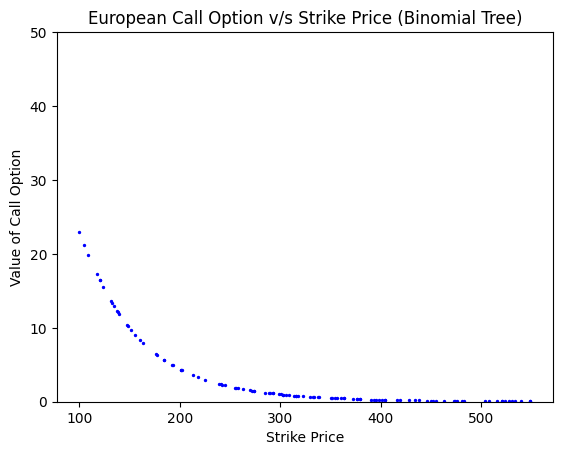

In [9]:
xpoints = dftree['Strike Price']
ypoints = dftree['Value of Call Option']
plt.scatter(xpoints, ypoints, s=2, color = 'blue')
plt.ylim(0,50)
#plt.hlines(y=math.pi, xmin = 0, xmax = 10000, colors='blue', linestyles='--', lw=1, label='Mathematical Value of Pi')
plt.title("European Call Option v/s Strike Price (Binomial Tree)")
plt.xlabel("Strike Price")
plt.ylabel("Value of Call Option")
plt.show()

In [10]:
#Method 3: Pricing an European Call Option using Monte Carlo Method
rng = np.random.default_rng(1000)
def EuropeanMC(S, K, T, r, sigma, N, Type = 'call'):
    Z = rng.normal(0, 1, N)
    ST = S*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    Future_value = 0
    if Type == 'call':
        Future_value = np.maximum(ST-K,0)
    elif Type == 'put':
        Future_value = np.maximum(K-ST, 0)
    else:
        raise ValueError(" Select 'call' or 'put'" )
    return np.mean(Future_value)*np.exp(-r*T)

In [11]:
def EuropeanMC_comparison(S, K, T, r, sigma, N, Type = 'call'):
    K = np.random.uniform(S,5*K,K)
    K = [math.trunc(K[i]) for i in range(len(K))]
    call_estimates = [round(EuropeanMC(S, K[i], T, r, sigma, N, Type='call'),2) for i in range(len(K))]
    return K , call_estimates

In [12]:
dfmc = EuropeanMC_comparison(100, 110, 2, 0.01, 0.4, 100, Type = 'call')
dfmc = pd.DataFrame(dfmc)
dfmc = dfmc.T
dfmc.columns = ["Strike Price", "Value of Call Option"]
dfmc = dfmc.sort_values(by = ['Strike Price'])
dfmc

,Strike Price,Value of Call Option
5,101.0,22.08
32,105.0,17.18
18,107.0,25.78
34,113.0,17.14
102,113.0,15.98
...,...,...
14,532.0,0.12
15,540.0,0.00
72,541.0,0.00
71,542.0,0.30


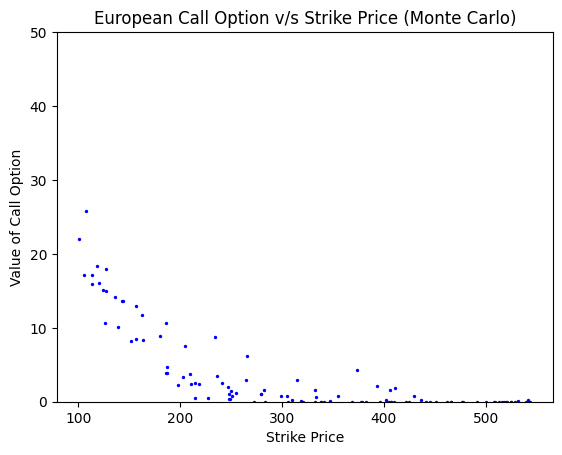

In [13]:
xpoints = dfmc['Strike Price']
ypoints = dfmc['Value of Call Option']
plt.scatter(xpoints, ypoints, s=2, color = 'blue')
plt.ylim(0,50)
#plt.hlines(y=math.pi, xmin = 0, xmax = 10000, colors='blue', linestyles='--', lw=1, label='Mathematical Value of Pi')
plt.title("European Call Option v/s Strike Price (Monte Carlo)")
plt.xlabel("Strike Price")
plt.ylabel("Value of Call Option")
#z = np.polyfit(xpoints, ypoints, 2)
#p = np.poly1d(z)
#plt.plot(xpoints,p(xpoints),"r--")
plt.show()

In [14]:
#Method 3: Pricing an European Call Option using Monte Carlo Method
# Added control variate: Delta of the European Call Option
rng = np.random.default_rng(123)
def EuropeanMCDeltaControl(S, K, T, r, sigma, N, Type = 'call'):
    Z = rng.normal(0, 1, N)
    ST = S #*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    cv = 0
    beta = -1
    Future_value = 0
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    for i in range(N): 
        if Type == "call":
            delta_option = stats.norm.cdf(d1, 0, 1)
            cv += delta_option*(ST - ST*np.exp(r*T))
            Future_value = np.maximum(ST-K,0) + beta*cv
        elif Type == "put":
            delta_option = -stats.norm.cdf(-d1, 0, 1)
            cv += delta_option*(ST - ST*np.exp(r*T))
            Future_value = np.maximum(K-ST,0) + beta*cv
        else:
            raise ValueError(" Select 'call' or 'put'" )
    return np.mean(Future_value*np.exp(-r*T))

In [15]:
def EuropeanMCDeltaControl_comparison(S, K, T, r, sigma, N, Type = 'call'):
    K = np.random.uniform(S,5*K,K)
    K = [math.trunc(K[i]) for i in range(len(K))]
    call_estimates = [round(EuropeanMCDeltaControl(S, K[i], T, r, sigma, N, Type='call'),2) for i in range(len(K))]
    return K , call_estimates

In [16]:
dfmcdeltacontrol = EuropeanMC_comparison(100, 110, 2, 0.01, 0.4, 100, Type = 'call')
dfmcdeltacontrol = pd.DataFrame(dfmcdeltacontrol)
dfmcdeltacontrol = dfmcdeltacontrol.T
dfmcdeltacontrol.columns = ["Strike Price", "Value of Call Option"]
dfmcdeltacontrol = dfmcdeltacontrol.sort_values(by = ['Strike Price'])
dfmcdeltacontrol

,Strike Price,Value of Call Option
97,100.0,25.17
91,103.0,29.42
106,111.0,22.74
23,116.0,8.95
18,117.0,11.23
...,...,...
28,538.0,0.00
64,543.0,0.00
20,544.0,0.00
103,546.0,0.00


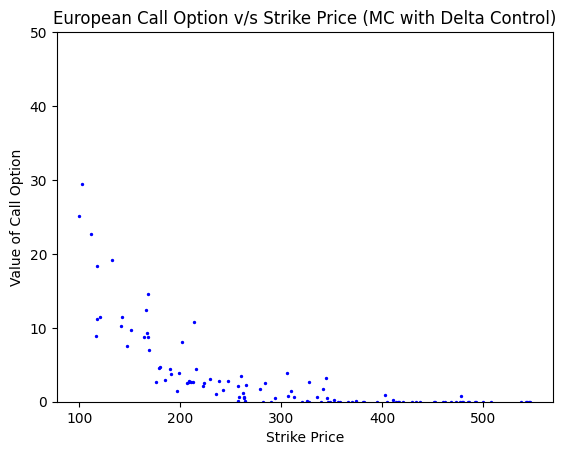

In [17]:
xpoints = dfmcdeltacontrol['Strike Price']
ypoints = dfmcdeltacontrol['Value of Call Option']
plt.scatter(xpoints, ypoints, s=2, color = 'blue')
plt.ylim(0,50)
#plt.hlines(y=math.pi, xmin = 0, xmax = 10000, colors='blue', linestyles='--', lw=1, label='Mathematical Value of Pi')
plt.title("European Call Option v/s Strike Price (MC with Delta Control)")
plt.xlabel("Strike Price")
plt.ylabel("Value of Call Option")
#z = np.polyfit(xpoints, ypoints, 6)
#p = np.poly1d(z)
#plt.plot(xpoints,p(xpoints),"r--")
plt.show()